In [2]:
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
import os
import shutil
import splitfolders
from PIL import Image
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Skin Cancer MNIST: HAM10000 - Exploratory data analysis & Skin lesion classification

Author: Filip Sosnowski

Dataset: [Skin Cancer MNIST: HAM10000](https://www.kaggle.com/datasets/kmader/skin-cancer-mnist-ham10000)

### 1. Exploratory data analysis

In [3]:
df = pd.read_csv("data/HAM10000_metadata.csv")
df.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10015 entries, 0 to 10014
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   lesion_id     10015 non-null  object 
 1   image_id      10015 non-null  object 
 2   dx            10015 non-null  object 
 3   dx_type       10015 non-null  object 
 4   age           9958 non-null   float64
 5   sex           10015 non-null  object 
 6   localization  10015 non-null  object 
dtypes: float64(1), object(6)
memory usage: 547.8+ KB


There are 10015 entries in this dataset. Each of the columns is of type object, besides 'age' (which is of type float64). It's also the only column, that contains null data.

In [5]:
df.shape[1], df.columns.tolist()

(7, ['lesion_id', 'image_id', 'dx', 'dx_type', 'age', 'sex', 'localization'])

There are 7 attributes in the metadata:
- lesion_id - unique identifier assigned to each lesion
- image_id - unique identifier assigned to each dermatoscopic image
- dx - diagnostic categories pigmented lesions
- dx_type - type of pigmented lesion
- age - age of a patient
- sex - gender of a patient
- localization - where the pigmented lesion is located

In [6]:
len(df['dx'].unique()), df['dx'].unique()

(7, array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object))

There are 7 diagnostic categories pigmented lesions:
- bkl - benign keratosis-like lesions
- nv - melanocytic nevi
- df - dermatofibroma
- mel - melanoma
- vasc - vascular lesions
- bcc - basal cell carcinoma
- akiec - actinic keratoses and intraepithelial carcinoma / Bowen's disease

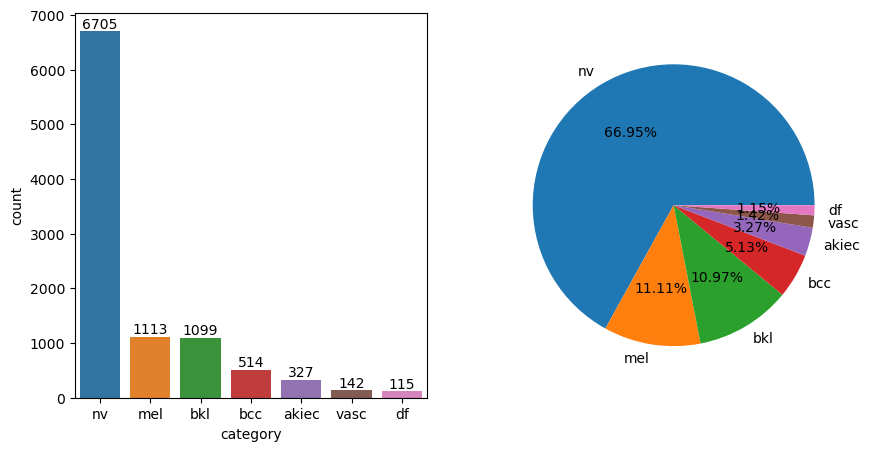

In [7]:
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
ax1 = sns.countplot(x=df['dx'].rename('category'), order=df['dx'].value_counts().index)
ax1.bar_label(ax1.containers[0])
plt.subplot(1,2,2)
plt.pie(x=df['dx'].value_counts(), labels=df['dx'].value_counts().index, autopct='%.2f%%')
plt.show()

We can see that there are way more records for 'nv' than in each of other categories. The dataset is imbalanced - it will be dealt with later.

In [8]:
df.isna().sum()

lesion_id        0
image_id         0
dx               0
dx_type          0
age             57
sex              0
localization     0
dtype: int64

There are 57 null values in 'age' column. I replaced the nulls with mean value of records in this column.

In [9]:
df['age'].fillna((df['age'].mean()), inplace=True)
df.isna().sum()

lesion_id       0
image_id        0
dx              0
dx_type         0
age             0
sex             0
localization    0
dtype: int64

<AxesSubplot:xlabel='age', ylabel='Count'>

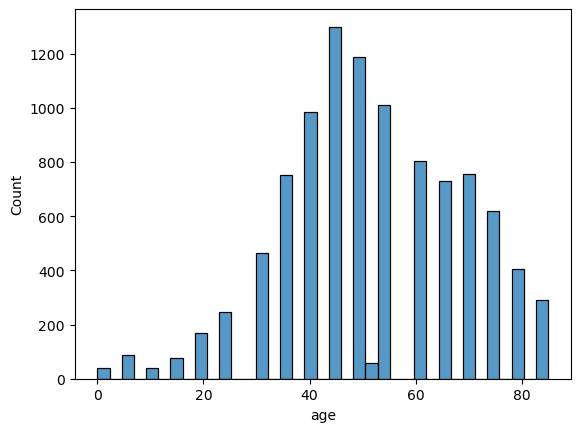

In [10]:
sns.histplot(data=df, x='age')

Most images come from patients who are between 40 and 60 years old. Below, I showed population pyramid for this data.

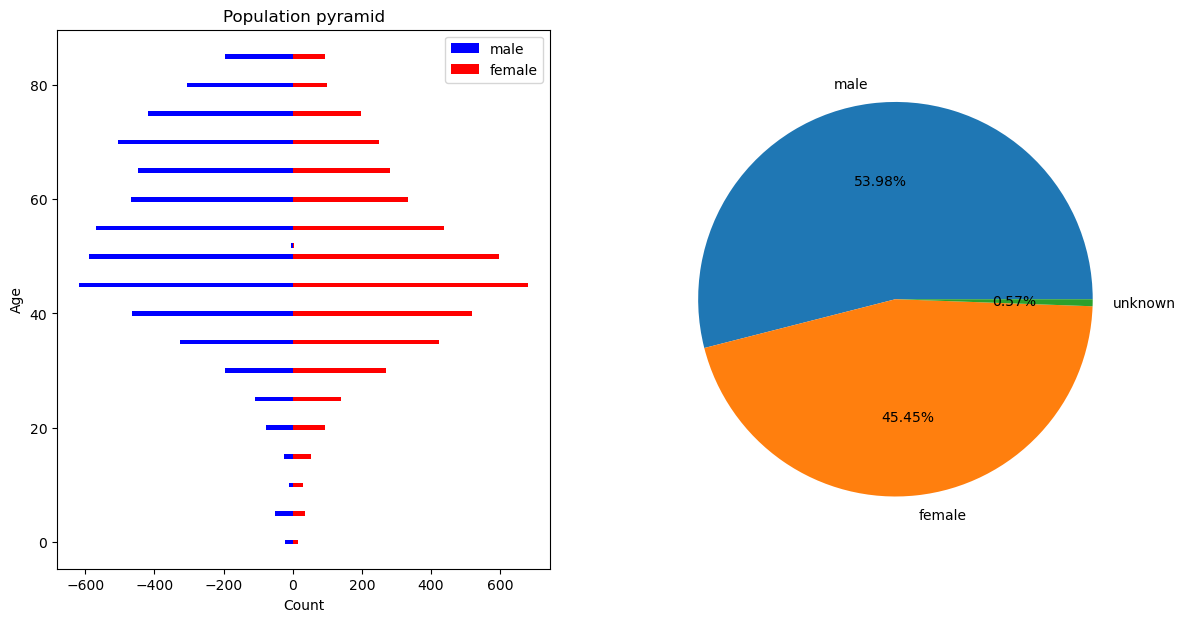

In [11]:
age_counts = df.groupby(['sex', 'age']).size()
age_counts_df = pd.DataFrame({'age': age_counts.index.get_level_values('age'),
                              'sex': age_counts.index.get_level_values('sex'),
                              'count': age_counts.values})

male_counts = age_counts_df[age_counts_df['sex'] == 'male']
female_counts = age_counts_df[age_counts_df['sex'] == 'female']
male_counts = male_counts.iloc[::-1]

plt.figure(figsize=(14,7))
plt.subplot(1,2,1)
plt.barh(male_counts['age'], -male_counts['count'], height=0.8, align='center', color='blue')
plt.barh(female_counts['age'], female_counts['count'], height=0.8, align='center', color='red')
plt.xlabel('Count')
plt.ylabel('Age')
plt.title('Population pyramid')
plt.legend(['male', 'female'])

plt.subplot(1,2,2)
plt.pie(x=df['sex'].value_counts(),labels=df['sex'].value_counts().index, autopct='%.2f%%')
plt.show()

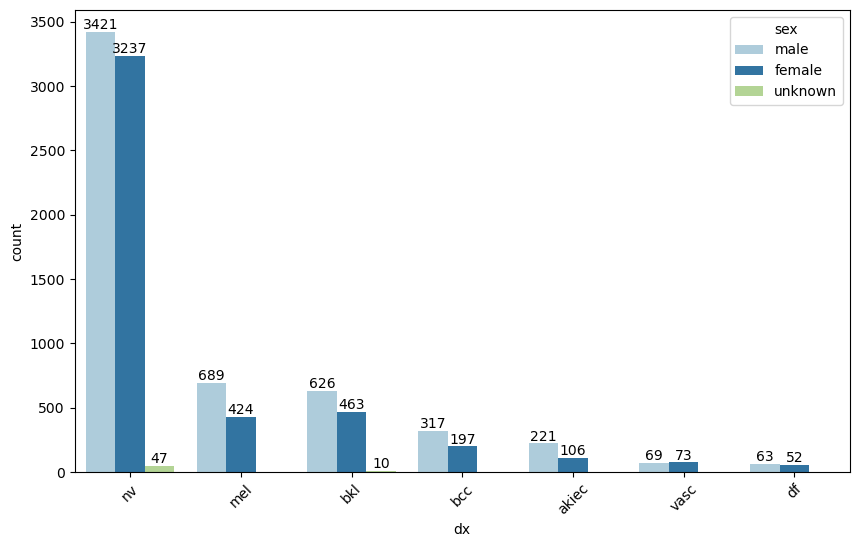

In [12]:
fig,axes = plt.subplots(figsize=(10,6))
ax = sns.countplot(x='dx',hue='sex', data=df, order = df['dx'].value_counts().index, palette = 'Paired')
for container in ax.containers:
    ax.bar_label(container)
plt.xticks(rotation=45)
plt.show()

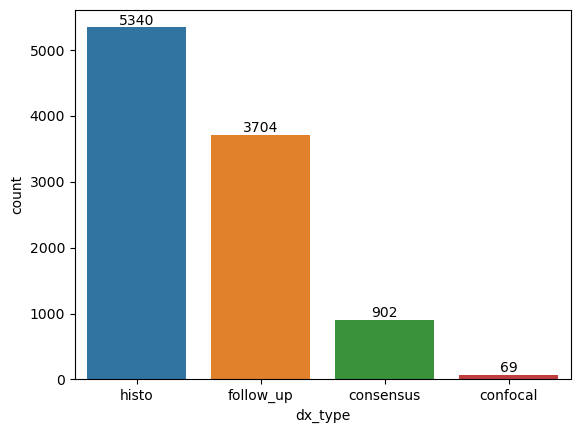

In [13]:
ax = sns.countplot(x=df['dx_type'], order=df['dx_type'].value_counts().index)
ax.bar_label(ax.containers[0])
plt.show()

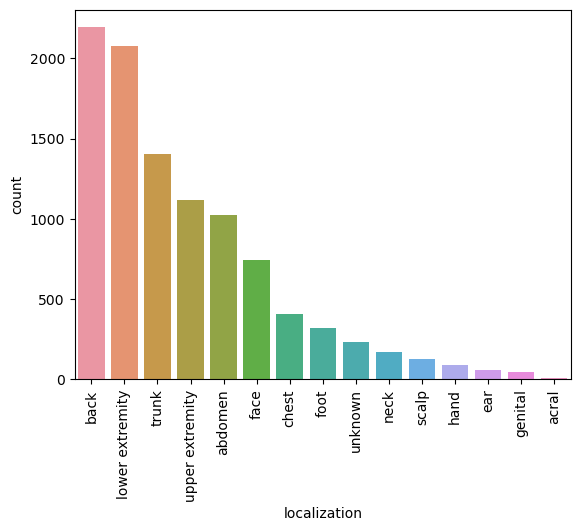

In [14]:
sns.countplot(x=df['localization'], order=df['localization'].value_counts().index)
plt.xticks(rotation=90)
plt.show()

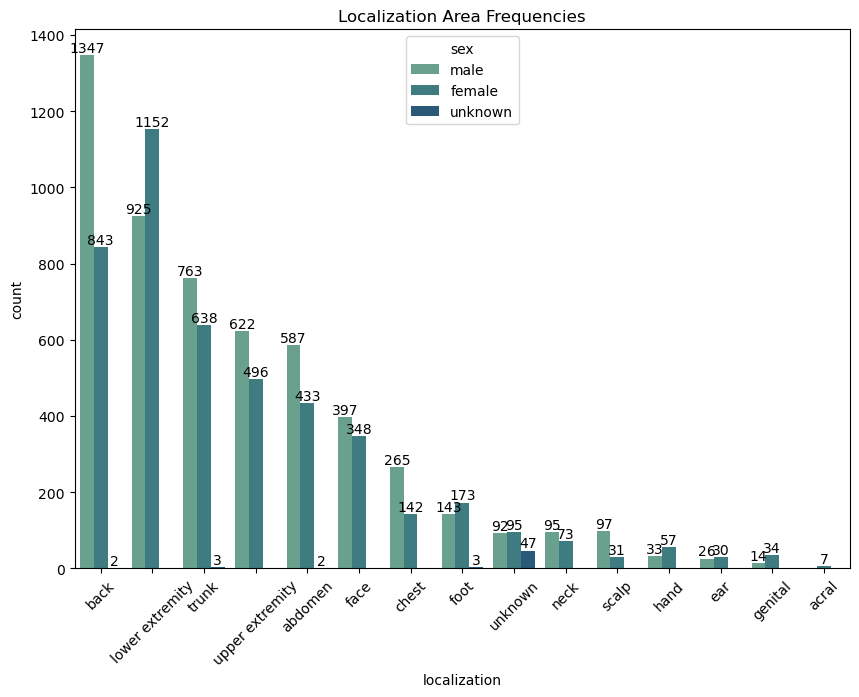

In [15]:
plt.figure(figsize=(10,7))
ax = sns.countplot(x='localization',hue='sex', data=df, order = df['localization'].value_counts().index, palette = 'crest')
for container in ax.containers:
    ax.bar_label(container)
plt.title('Localization Area Frequencies')
plt.xticks(rotation=45)
plt.show()

It can be observed that the most common localizations of skin lesions are: back, low externity and trunk.

### 2. Skin lesion classification

In [16]:
num_of_lesions = len(df['lesion_id'].value_counts())
num_of_lesions, df.shape[0]-num_of_lesions

(7470, 2545)

Although there are 10015 different images, 2545 of them are similiar photos taken of the same lesion (those images have an adequate lesion_id assigned). In conclusion, there are 7470 unique lesion_id's. I've decided to remove the duplicates. 

In [17]:
df = df.drop_duplicates(subset=['lesion_id'])

In [18]:
# number of records after dropping duplicates
df.shape[0]

7470

In [19]:
# data directories paths
original_dir = os.getcwd() + "/data/HAM10000_images/"
classes_dir = os.getcwd() + "/data/HAM10000_images_organized/"
split_dir = os.getcwd() + "/data/HAM10000_images_split/"

In [20]:
if os.path.exists(classes_dir):
    shutil.rmtree(classes_dir)
if os.path.exists(split_dir):
    shutil.rmtree(split_dir)

os.makedirs(classes_dir)
os.makedirs(split_dir)

In [21]:
labels = df['dx'].unique()
labels

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

In [22]:
# sorting labels into adequate folders
for label in labels:
    os.makedirs(classes_dir + str(label) + '/', exist_ok=True)
    for image_id in df[df['dx'] == label]['image_id']:
        shutil.copyfile((original_dir + image_id + ".jpg"),(classes_dir + label + "/" + image_id + ".jpg"))

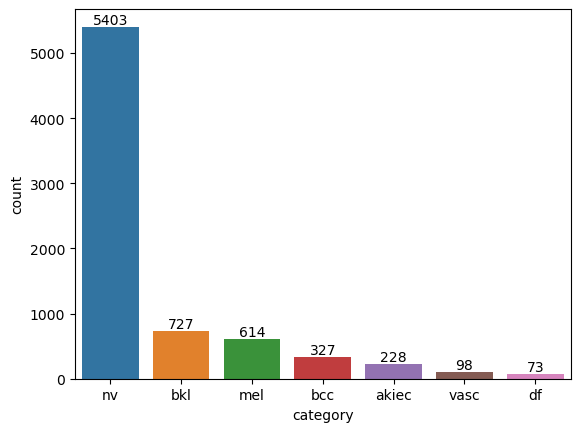

In [23]:
ax = sns.countplot(x=df['dx'].rename('category'), order=df['dx'].value_counts().index)
ax.bar_label(ax.containers[0])
plt.show()

The dataset is imbalanced - category 'nv' has about 5000 more records. Later on, I will solve this problem with oversampling with augmented images.

### Splitting images into three directories: train, test, validation

In [24]:
splitfolders.ratio(classes_dir, output=split_dir, seed=1337, ratio=(.8, .1, .1))

Copying files: 7470 files [00:35, 209.74 files/s]


In [25]:
parent_directory = split_dir + "train/"
os.listdir(parent_directory)

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']

#### Oversampling:

Number of images in each category before oversampling:

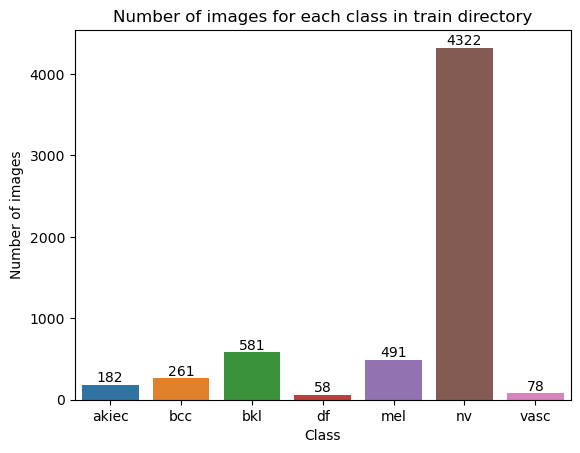

In [26]:
train_dir = split_dir + "train/"
subdirs = [name for name in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, name))]
subdir_names = []
file_counts = []

for subdir in subdirs:
    subdir_path = os.path.join(train_dir, subdir)
    file_count = len(os.listdir(subdir_path))
    subdir_names.append(subdir)
    file_counts.append(file_count)

ax = sns.barplot(x=subdir_names, y=file_counts)
ax.bar_label(ax.containers[0])
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Number of images for each class in train directory')
plt.show()

Generating new images:

In [27]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=180,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)

In [28]:
max_samples = 0
for folder_name in os.listdir(parent_directory):
    folder_path = os.path.join(parent_directory, folder_name)
    images_in_dir = len([f for f in os.listdir(folder_path) if f.endswith('.jpg')])
    if(max_samples < images_in_dir):
        max_samples = images_in_dir

In [29]:
import math
train_dir = split_dir + "train/"

for folder_name in os.listdir(train_dir):
    folder_path = os.path.join(train_dir, folder_name)
    images_in_dir = len([f for f in os.listdir(folder_path) if f.endswith('.jpg')])
    if (images_in_dir != max_samples):
        num_of_images_needed = max_samples - images_in_dir
        augmented_images_per_original = math.ceil(num_of_images_needed / images_in_dir)

        for filename in os.listdir(folder_path):
            img_path = os.path.join(folder_path, filename)
            img = Image.open(img_path)

            #generating augmented images
            img_array = np.array(img)
            img_array = img_array.reshape((1,) + img_array.shape)
            i = 0
            for batch in datagen.flow(img_array, batch_size=1, save_to_dir=folder_path, save_prefix='aug_', save_format='jpg'):
                i += 1
                if i > augmented_images_per_original:
                    break

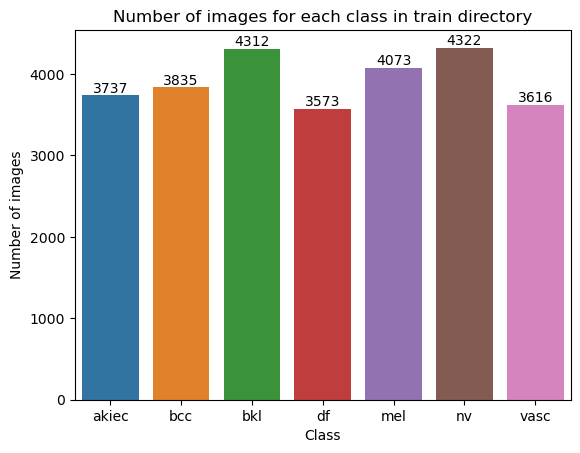

In [30]:
train_dir = split_dir + "train/"
subdirs = [name for name in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, name))]
subdir_names = []
file_counts = []

for subdir in subdirs:
    subdir_path = os.path.join(train_dir, subdir)
    file_count = len(os.listdir(subdir_path))
    subdir_names.append(subdir)
    file_counts.append(file_count)

ax = sns.barplot(x=subdir_names, y=file_counts)
ax.bar_label(ax.containers[0])
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Number of images for each class in train directory')
plt.show()

In [31]:
gen = ImageDataGenerator(rescale=1./255)

train_dir = split_dir + "train/"
val_dir = split_dir + "val/"
test_dir = split_dir + "test/"

target_size = (75, 100)
batch_size = 10

train_data = gen.flow_from_directory(
   directory=train_dir,
   target_size=target_size,
   batch_size=batch_size
)
val_data = gen.flow_from_directory(
   directory=val_dir,
   target_size=target_size,
   batch_size=batch_size
)
test_data = gen.flow_from_directory(
   directory=test_dir,
   target_size=target_size,
   batch_size=batch_size
)

Found 27468 images belonging to 7 classes.
Found 743 images belonging to 7 classes.
Found 754 images belonging to 7 classes.


In [32]:
train_data.class_indices

{'akiec': 0, 'bcc': 1, 'bkl': 2, 'df': 3, 'mel': 4, 'nv': 5, 'vasc': 6}

In [33]:
train_data.samples, val_data.samples

(27468, 743)

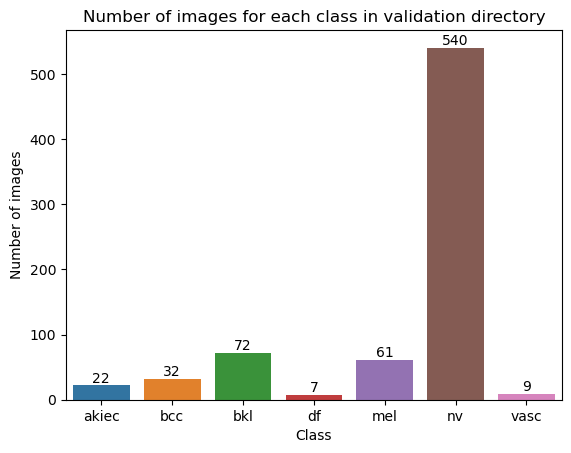

In [34]:
val_dir = split_dir + "val/"
subdirs = [name for name in os.listdir(val_dir) if os.path.isdir(os.path.join(val_dir, name))]
subdir_names = []
file_counts = []

for subdir in subdirs:
    subdir_path = os.path.join(val_dir, subdir)
    file_count = len(os.listdir(subdir_path))
    subdir_names.append(subdir)
    file_counts.append(file_count)

ax = sns.barplot(x=subdir_names, y=file_counts)
ax.bar_label(ax.containers[0])
plt.xlabel('Class')
plt.ylabel('Number of images')
plt.title('Number of images for each class in validation directory')
plt.show()

### CNN model

In [35]:
input_shape = train_data.image_shape
num_classes = len(df['dx'].unique())

# feature learning
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same', input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size = (2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(Conv2D(64, (3, 3), activation='relu', padding = 'same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.40))

# classification
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 75, 100, 32)       896       
                                                                 
 conv2d_1 (Conv2D)           (None, 75, 100, 32)       9248      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 37, 50, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 37, 50, 32)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 37, 50, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 37, 50, 64)        36928     
                                                        

In [36]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [37]:
epochs=50
history = model.fit(train_data, steps_per_epoch=train_data.samples//train_data.batch_size, validation_data=val_data, epochs=epochs)

Epoch 1/50
2746/2746 [==============================] - 2190s 797ms/step - loss: 1.5978 - accuracy: 0.3736 - val_loss: 0.9641 - val_accuracy: 0.6635
Epoch 2/50
2746/2746 [==============================] - 623s 227ms/step - loss: 1.2994 - accuracy: 0.4920 - val_loss: 0.8382 - val_accuracy: 0.7079
Epoch 3/50
2746/2746 [==============================] - 582s 212ms/step - loss: 1.2084 - accuracy: 0.5270 - val_loss: 0.7805 - val_accuracy: 0.7402
Epoch 4/50
2746/2746 [==============================] - 583s 212ms/step - loss: 1.1467 - accuracy: 0.5521 - val_loss: 0.7784 - val_accuracy: 0.7389
Epoch 5/50
2746/2746 [==============================] - 581s 212ms/step - loss: 1.0990 - accuracy: 0.5737 - val_loss: 0.7508 - val_accuracy: 0.7510
Epoch 6/50
2746/2746 [==============================] - 576s 210ms/step - loss: 1.0583 - accuracy: 0.5902 - val_loss: 0.7376 - val_accuracy: 0.7631
Epoch 7/50
2746/2746 [==============================] - 578s 211ms/step - loss: 1.0273 - accuracy: 0.5994 - val

In [38]:
import time
timestr = time.strftime("%Y%m%d_%H%M")
filepath =  "model/model_" + timestr + ".h5"
model.save(filepath)

In [ ]:
tf.keras.utils.plot_model(
    model,
    show_shapes=True,
    show_layer_names=True,
    rankdir="TB",
    expand_nested=True,
    dpi=96,
)

In [40]:
def show_performance_curve(training_result, metric, metric_label):
    
	train_perf = training_result.history[str(metric)]
	validation_perf = training_result.history['val_'+str(metric)]
	intersection_idx = np.argwhere(np.isclose(train_perf,
                                            	validation_perf, atol=1e-2)).flatten()[0]
	intersection_value = train_perf[intersection_idx]
    
	plt.plot(train_perf, label=metric_label)
	plt.plot(validation_perf, label = 'val_'+str(metric))
	plt.axvline(x=intersection_idx, color='r', linestyle='--', label='Intersection')
    
	plt.annotate(f'Optimal Value: {intersection_value:.4f}',
         	xy=(intersection_idx, intersection_value),
         	xycoords='data',
         	fontsize=10,
         	color='green')
            	 
	plt.xlabel('Epoch')
	plt.ylabel(metric_label)
	plt.legend(loc='lower right')

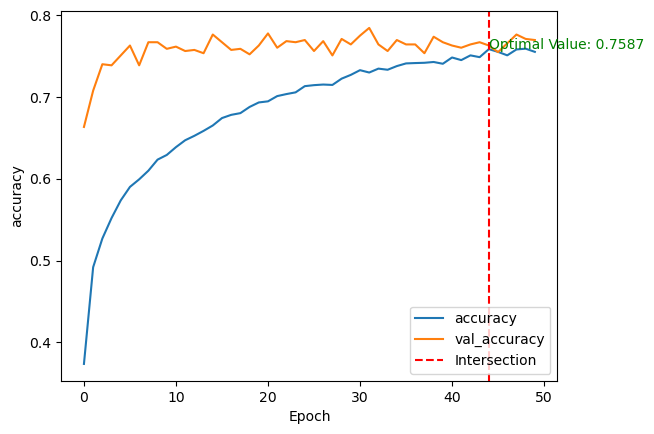

In [41]:
show_performance_curve(history, 'accuracy', 'accuracy')

### Evaluation

In [43]:
results = model.evaluate(test_data)
print('test loss, test accuracy:', results)

76/76 [==============================] - 6s 80ms/step - loss: 1.0033 - accuracy: 0.7546
test loss, test accuracy: [1.0033292770385742, 0.7546418905258179]


76/76 [==============================] - 5s 69ms/step


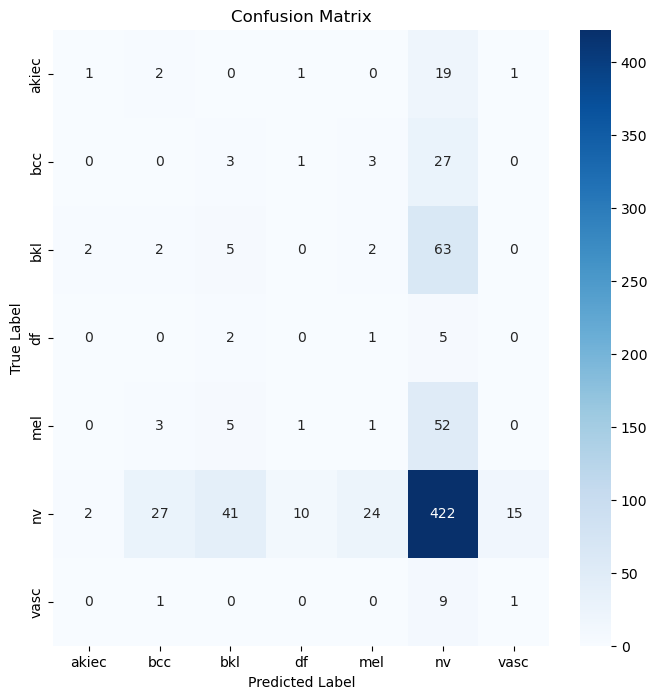

In [44]:
from sklearn.metrics import confusion_matrix

y_pred = model.predict(test_data)
y_pred = np.argmax(y_pred, axis=1)

y_true = test_data.classes

class_labels = list(test_data.class_indices.keys())

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap=plt.cm.Blues, xticklabels=class_labels, yticklabels=class_labels)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()